# Computer Networks Final Project

Maxim Torubarov

In this project I analyze customer complaints, requests, and queries that are send to a company. The company keeps track of these messages as tickets. All of the tickets (64016 of them) are kept in tickets_details.csv which consists of rows of tickets each with 7 different columns: Ticket ID, Subject, Description, Status, Type, Created time, and Contact_id. 
-	Ticket ID is a unique identifier for each ticket. 
-	Subject is the subject of the message. 
-	Description is the main message that the customers write. 
-	Status is either Closed, Resolved, or Open and indicates whether or not the company has dealt with the ticket
-	Type is the type of ticket
-	Created time is the time when the ticket was created
-	Contact_id is the customer’s id. There may be more than 1 ticket per Contact_id

The tickets span from 5/8/17 through 2/26/18.
My project is split into 3 parts: classification, sentiment analysis, and analytics. We proceed by describing the first part.


# Classification

The goal of this part was to classify the descriptions into types. So, for example, a description talking about cancelling an order should be classified as a “Classification” type. There are a total of 38 classes (including a few I get rid off later) which is a lot. 

## Imports

In [121]:
import csv
import pandas as pd
import random
import re
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
import numpy as np
import operator
import collections

## Get Data and Preprocess

Before classifying anything, I had to get the data from the file and preprocess it. I went row by row in the data and for each element in the row (corresponding to a column), I put the element in one of the 7 arrays (one for each column). In this step, I also took care of several bad rows. Namely, I ignored any row with an empty string in the type column or the description column since these rows don’t really hold any useful information. I also found another row with “binalg@yahoo.com” in its type column. This was the only row with this type and the string doesn’t mean anything, so I took out the row as well. Next, I looked at the types and noticed that some of them are very similar to one another at least by name. These similar types and how I dealt with them are as follows:
-	“Cancellation” and “Cancellation// RTO”: I noticed that descriptions having this type were generally very similar in what they were saying: for both, the descriptions are requests to cancel some order. Furthermore, there were only 49 cases of “Cancellation” type whereas there were 1660 cases of the other type. I figured that both these types were categorizing very similar if not the same things so for every row with “Cancellation// RTO” type, I changed it to “Cancellation type”. Perhaps there are two classifications here because the company has some other knowledge on the ticket that this excel document doesn’t provide us, like what state the order is currently in.
-	“Offer Query” and “Offer Related”: “Offer Query” appears only until 11/5/2017 after which it doesn’t appear again. After this, only “Offer Related” is used. Once again, descriptions in both types appeared to be very similar. Furthermore, “Offer Query” appeared only 7 times as opposed to 70 so it’s not like they were trying to describe two different common types of descriptions. It appears as if the human annotators used both at first, and then realized they were the same thing and only used “Offer Related” from then on. So like before, I changed each “Offer Query” entry to “Offer Related”
-	“Order Related” and “Order Related Request”: Analyzing descriptions of both types, I noticed that they were very similar if not the same. Because, the “Order Related” type was used significantly more than the other tag(26248 vs 414), I figured that “Order Related Request” was just a subset of “Order Related”. I joined both of these tags by changing each “Order Related Request” tag to “Order Related”.

I found that these small changes in types produced good improvements in the results.


In [86]:
#arrays that store the data from each of the columns
ticketIDs = []
subjects = []
descriptions = []
statuses = []
types = []
createdTimes = []
contactIds = []

#open the file and preprocess the data
with open ('tickets_details.csv',newline = '') as csvfile:
    reader = csv.reader(csvfile)
    next(reader)
    for row in reader:
        #ignore rows with "" as types or descriptions
        if(row[2]=="" or row[4]==""):
            continue
            
        #ignore the 1 row with an email address for type
        if("binalg" in row[4]):
            continue
        
        #join "Cancellation" and "Cancellation //RTO" types
        if("Cancellation" in row[4][:13]):
            row[4] = 'Cancellation'
            
        #join "Offer Query" and "Offer Related" types
        if("Offer" in row[4][:5]):
            row[4]="Offer Related"
            
        #join "Order Related" and "Order Related Request"
        if("Order Related" in row[4]):
            row[4]="Order Related" 
        
        #add the elements to the corresponding arrays
        ticketIDs.append(row[0])
        subjects.append(row[1])
        descriptions.append(row[2])
        statuses.append(row[3])
        types.append(row[4])
        createdTimes.append(row[5])
        contactIds.append(row[6])

In [7]:
#this is the classes of things that the descriptions can be
classes = list(set(types))
classes = sorted(classes)


In [122]:
#shuffle all the data around
indeces = [i for i in range(len(descriptions))]

random.shuffle(indeces)
ticketIDs = [ticketIDs[i] for i in indeces]
subjects= [subjects[i] for i in indeces]
descriptions= [descriptions[i] for i in indeces]
statuses= [statuses[i] for i in indeces]
types= [types[i] for i in indeces]
createdTimes= [createdTimes[i] for i in indeces]
contactIds= [contactIds[i] for i in indeces]

## Further Preprocessing: lowercasing, getting rid of punctuations, spell checking

A huge difficulty with this data is the amount of spelling errors in the descriptions. Many common English words were misspelled which is problematic for a classifier which sees a misspelled word and its correct spelling as two different words. To deal with this, I first create a vocabulary of all the different words in the description. Then I correct some of the mispelled words

In [18]:
#method that given some text, splits it up into word tokens
def getWordsList(text): 
    return re.findall(r'\w+', text.lower())


#stores each element of descriptions list as a list of words instead of a full sentence
descriptionsWords = []

#a Counter of all the words in the descriptions and the number of times they occur
vocabulary=Counter()

#get descriptionWords and vocabulary
for entry in descriptions:
    allWords = getWordsList(entry)
    descriptionsWords.append(allWords)
    for word in allWords:
        if(word in vocabulary):
            vocabulary[word] = vocabulary[word] + 1
        else:
            vocabulary[word]=1

In [19]:
#if a word appears less than this threshold, that means that it is very unlikely to be a correct spelling
threshold = 2

#the total number of words in all the descriptions
totalNumberWords= sum(vocabulary.values())

#The following methods are inspired by http://norvig.com/spell-correct.html

#the number of times the word appears in the descriptions / total number of words in the descriptions
def probability(word):
    return vocabulary[word]/totalNumberWords

#the most likely spelling correction
#returns dictionary of possible words that is sorted
def correction(word): 
    #weights depending on type of word
    probItself=50
    probEdits1 = 4
    probEdits2 = 1
    
    possibleCandidates = {}
    
    probOfThisWord = probability(word)
    if(probOfThisWord == 0 ):
        probOfThisWord = 1/totalNumberWords
    possibleCandidates[word]=probOfThisWord*probItself
    
    for w in edits1(word):
        if w not in possibleCandidates:
            possibleCandidates[w] = probability(w)*probEdits1
    for w in edits2(word):
        if w not in possibleCandidates:
            possibleCandidates[w] = probability(w)*probEdits2

    sortedDict = collections.OrderedDict(sorted(possibleCandidates.items(),key=operator.itemgetter(1),reverse=True))#sorted(possibleCandidates.items(), key = lambda(k,v): (v,k))
    
    return dict(sortedDict)

#returns candidates for the word
def candidates(word): 
    return (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])
    
#Returns the words that appear in the vocabulary
def known(words): 
    return set(w for w in words if w in vocabulary and vocabulary[w]>=threshold)

#Returns all words that are 1 edit away from the input word
def edits1(word):
    letters = 'abcdefghijklmnopqrstuvwxyz'
    splits = [(word[:i], word[i:]) for i in range(len(word) + 1)]
    deletes = [L + R[1:] for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces = [L + c + R[1:] for L, R in splits if R for c in letters]
    inserts = [L + c + R for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

#Returns all words that are 2 edits away from the input word
def edits2(word): 
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))



The following takes a while so if you don't want to do the spellchecking feel free to make "doSpellChecking" = False

In [20]:
doSpellChecking = False
if(doSpellChecking):

    #we go through every entry: make it lowercase, and correct spelling
    progress = 0
    newDescriptions = []
    for index,entry in enumerate(descriptions):
        words = descriptionsWords[index]
        updatedWords = ""
        for word in words:
            updatedWords = updatedWords+ " " + list(correction(word).keys())[0]  #list(my_dict.keys())[0]
        newDescriptions.append(updatedWords)
        progress+=1
        if(progress%10 == 0):
            print("p:",progress)
    descriptions = newDescriptions

## Splitting Data

In [21]:
#EXPERIMENT:
#using just descriptions to classify into types


#first get the test, dev, train split: 70% is training, 30% is split into mix(30% dev, 70% test)
#62000 rows in total
trainingPercentage = .8#.7
devPercentage = .8+.2*.2#.79


size=len(descriptions)
ttrain_x=descriptions[:int(trainingPercentage*size)]
ttrain_y=types[:int(trainingPercentage*size)]
tdev_x=descriptions[int(trainingPercentage*size):int(devPercentage*size)]
tdev_y=types[int(trainingPercentage*size):int(devPercentage*size)]
ttest_x=descriptions[int(devPercentage*size):]
ttest_y=types[int(devPercentage*size):]

## Playing Around with Data

This is an example method I used to look at the data based on type

In [23]:
#look at descriptions of specific type
typeNum=5


def getSpecificX(type, allX , allY):
    print("looking for data with type: " + type)
    x = []
    for i in range(len(allY)):
        if(type == allY[i]):
            x.append(allX[i])
    return x

#x = getSpecificX(classes[typeNum], ttrain_x, ttrain_y)
x = getSpecificX(classes[typeNum], ttrain_x+tdev_x, ttrain_y+tdev_y)

print("this type appears: ",len(x)," times")
for e in x:
    print("------------------")
    print(e)

looking for data with type: Cancellation
this type appears:  1451  times
------------------
Order Id: 5a92cd93dc75c841113f771a Cancel this order buyer didn't get how order it. Please write above this line. With Regards, Munish Kumar Wipro Jaipur 8059485007 & 9649833408 
------------------
Order Id: 5a77c310b5d4760bc704f4c0 I want to cancel this order Please write above this line. 
------------------
Order Id: 5a93968846833b20cdca40a2 Cancel the order Please write above this line. 
------------------
Order Id: 5a7c114788ccd868141bc274 Kindly cancel that order.customer ordered by mistake Please write above this line. 
------------------
Order Id: 5a91ed1f238b550bbe5fec90 i don't want to sell it..pls cancel the order Please write above this line. 
------------------
I wish to cancel order number ID 602410 Please write above this line. Don’t forget to mention your Order ID in the mail text. 
------------------
Order Id: 5a8415787168e1484613f9fa Pleas kindly cancel the order Please write ab

------------------
Order Id: 5a63237f5b08ac0b4f69d043 I want to cancell this oder Please write above this line. 
------------------
Order Id: 5a79b93d31dfd8693a86f8a5 Please write above this line. why problem are product cancel.why? 
------------------
Order Id: 5a720a0f28972c65d8400941 Please cancel this order 
------------------
Order Id: 5a958c940d9cab3dc14ef16f The order was placed by mistake please cancel it and sry for trouble Please write above this line. 
------------------
Order Id: 5a69f99360a78f7aacdf5e79 The seller said that she shipped the product. Why is it showing not shiped Please write above this line. 
------------------
Hi I would like to cancel my order 622477, for I want to add a few more things in it. Pls help me & cancel my order at the earliest.. Thanks Sharan juneja 
------------------
Order Id: 5a7870dcc06e8076b28652e3 Please cancel this order Please write above this line. 
------------------
601963 Please write above this line. Don’t forget to mention your Or

Order Id: 5a718a0c1bd17359e6b36d00 Please write above this line.__ ____ _____ __ _____ ___ _____ ____ ____ __ ___ __ ____ __ __ __ ______ __ Sent from Yahoo Mail on Android 
------------------
Order Id: 5a7201b4128f9212e654a560 Hi , as I m out of town and buyer booked it without asking availability ,so it's a request to plz cancel the order or reschedule it for 24th feb as I will be available by the time. Please write above this line. 
------------------
Order Id: 5a831530a2dd2379dc02b394 The said product already revived by me. Why it is showing as in process again Please write above this line. 
------------------
Order Id: 5a8a720c0917340d803038b1 Please cancel the above order. Please write above this line. 
------------------
Order Id: 5a7fe5ad8296d04b7b905f70 Please write above this line. I need to cancel this order. It was ordered by mistake 
------------------
Order Id: 5a86f0242949270383df160e Pls cancel my order Please write above this line. 
------------------
Hi pls cancel thi

------------------
Cancel this order please On 27 Jan 2018 11:52 a.m., "Elanic" <no-reply@elanic.co> wrote: > *ORDER PLACED* > > Hi crazycollection > We are pleased to confirm your purchase with Order ID 599540 > Thank you for shopping with Elanic! > Manage Order > <https://mandrillapp.com/track/click/30538061/elanic.app.link?p=eyJzIjoiUDNyaFUwUDRRQ2poNFNKRjhuWkFDRzFxZENRIiwidiI6MSwicCI6IntcInVcIjozMDUzODA2MSxcInZcIjoxLFwidXJsXCI6XCJodHRwczpcXFwvXFxcL2VsYW5pYy5hcHAubGlua1xcXC8ydnhvVjM4QTJKXCIsXCJpZFwiOlwiZWY5YzE2NzZkODcxNDgyYzg1ZTg0YTk0MTE0ZmUyZDBcIixcInVybF9pZHNcIjpbXCJiNTA5MGZmNzU1NGJlNGFmMTU3YjEwNzU1ODI0N2U2ZDBlNTViZTBkXCJdfSJ9> > > *Delivery Address* > Antra Das > 31,Dr.Gangadhar Mukherjee Road. Howrah > <https://maps.google.com/?q=31,Dr.Gangadhar+Mukherjee+Road.+Howrah&entry=gmail&source=g>-7111 > 01. Fazir Bazar. Near Vivek Vihar. Near Corporation Bank. Opposite > Food.Com. Above Seema Studio. 2nd Floor > Howrah City > Howrah City - 711101 > Mob: 8274927232 > Ruffle Top Seller: l

# Make data into a count vector, test


In [24]:
count_vect= CountVectorizer()
X_train_counts = count_vect.fit_transform(ttrain_x)

In [25]:
#TEST size of training set
X_train_counts.shape
#first number is the amount of rows in the train
#second number is the size of the vocabulary for this

(50177, 96549)

In [26]:
#TEST size of contact ids (not very interesting)
print(len(contactIds))
setContactIds = set(contactIds)
print("how many contact id's not unique:",len(contactIds)-len(setContactIds))    #45000

62722
how many contact id's not unique: 45611


# Classifiers

In [39]:
class Experiment(object):
    def __init__(self, ntrain_x, ntrain_y, ndev_x, ndev_y, ntest_x, ntest_y):
        self.train_x=list(ntrain_x)
        self.train_y=list(ntrain_y)
        self.classes = sorted(set(self.train_y))
        self.dev_x=list(ndev_x)
        self.dev_y=list(ndev_y)
        self.test_x=list(ntest_x)
        self.test_y=list(ntest_y)
    
    
    def transformSoThatClassAppears(self, times):
        
        counter = Counter(self.train_y)
        print(counter)
        toKeep = []
        for c in counter:
            if(counter[c]<times):
                pass
            else:
                toKeep.append(c)
        print(len(toKeep))
        print(toKeep)
        index = 0
        while index < len(self.train_y):
            y = self.train_y[index]
            if(y not in toKeep):
                del self.train_x[index]
                del self.train_y[index]
            else:
                index+=1
        index=0
        while index < len(self.dev_y):
            y = self.dev_y[index]
            if(y not in toKeep):
                del self.dev_x[index]
                del self.dev_y[index]
            else:
                index+=1
        index=0
        while index<len(self.test_y):
            y = self.test_y[index]
            if(y not in toKeep):
                del self.test_x[index]
                del self.test_y[index]
            else:
                index+=1
        self.classes = sorted(set(self.train_y))
    
    #for following: test is if true, then we use test_x instead
    #TODO: add this functionality
    def predict(self,pipeline, test=False):
        
        pipeline.fit(self.train_x, self.train_y) 
        if(test==False):
            dev_predicted = pipeline.predict(self.dev_x)
            return dev_predicted
        else:
            test_predicted = pipeline.predict(self.test_x)
            return test_predicted
    
    
    
    def printAccuracy(self,prediction, test=False):
        if(test==False):
            return np.mean(prediction==self.dev_y)
        else:
            return np.mean(prediction ==self.test_y)
            
    def printConfusionMatrix(self, prediction, test = False):
        if(test==False):
            print(metrics.classification_report(self.dev_y, prediction))
        else:
            print(metrics.classification_report(self.test_y, prediction))
    
e = Experiment(ttrain_x,ttrain_y,tdev_x,tdev_y,ttest_x,ttest_y)
e.transformSoThatClassAppears(5) 
    #makes it so that we don't look at rows whose label is one that appears less than specified number of times in the testing data
    #this method gets rid of types that don't appear often. Improves accuracy a lot.

Counter({'Order Related': 21398, 'Pickup Related': 6160, 'Delivery Related': 3640, 'Return/SBS': 3495, 'Payment Related': 2932, 'General Query': 2798, 'Other': 2089, 'SBS Related': 1689, 'Cancellation': 1371, 'Cash-Out Related': 1198, 'Feedback/ Feature Request': 928, 'Tech Related': 505, 'Ops Query': 355, 'Shipping Label': 221, 'Pre-sales queries': 208, 'Listing/Post Related': 181, 'Ops Complaint': 149, 'Account Related': 143, 'Refund Issue': 140, 'Damage': 85, 'Serviceability Query': 80, 'Referral': 79, 'App Related': 71, 'Offer Related': 65, 'Marketing Emails': 42, 'Post Sales queries': 41, 'Shipping Charges Queries': 36, 'Packaging Issues': 33, 'Career Related': 18, 'Privacy Violation': 17, 'Amount Debited order confirmed': 4, 'Bank Statement': 2, 'Address Mismatch': 2, 'SBS Request': 1, 'Test': 1})
30
['Return/SBS', 'Order Related', 'Ops Query', 'Delivery Related', 'General Query', 'Pickup Related', 'Payment Related', 'Cash-Out Related', 'Other', 'Cancellation', 'SBS Related', 'Re

In [40]:
#EXPERIMENT 1: vect, tfidf, clf=MultinomialNB
pipeline = Pipeline([('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer()),
                      ('clf', MultinomialNB()),
])
prediction = e.predict(pipeline, True)
e.printAccuracy(prediction, True)

0.43946188340807174

In [41]:
#EXPERIMENT 2: vect, clf=MultinomialNB
pipeline = Pipeline([('vect', CountVectorizer()),
                      ('clf', MultinomialNB()),
])
prediction = e.predict(pipeline, True)
e.printAccuracy(prediction, True)

0.46447433981066266

In [42]:
#EXPERIMENT 3: vect, tfidf, clf=SGD
pipeline = Pipeline([('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer()),
                      ('clf', SGDClassifier(loss='hinge', penalty='l2',
                                            alpha=1e-3, random_state=42,
                                            max_iter=5, tol=None)),
])
prediction = e.predict(pipeline, True)
e.printAccuracy(prediction, True)

0.49377179870453414

In [43]:
#EXPERIMENT 4: vect, clf=SGD

pipeline = Pipeline([('vect', CountVectorizer()),
                      ('clf', SGDClassifier(loss='hinge', penalty='l2',
                                            alpha=1e-3, random_state=42,
                                            max_iter=5, tol=None)),
])
prediction = e.predict(pipeline, True)
e.printAccuracy(prediction, True)

0.50981564524165424

It seems that count vectorizer does better without tfidf than with.

In [44]:
e.printConfusionMatrix(prediction, True)
#support is the number of times that class appears in the y

                           precision    recall  f1-score   support

          Account Related       0.56      0.16      0.25        31
              App Related       0.00      0.00      0.00        14
             Cancellation       0.00      0.00      0.00       258
           Career Related       0.00      0.00      0.00         7
         Cash-Out Related       0.67      0.76      0.71       259
                   Damage       0.33      0.05      0.09        19
         Delivery Related       0.31      0.02      0.03       706
Feedback/ Feature Request       0.34      0.14      0.19       176
            General Query       0.41      0.13      0.20       551
     Listing/Post Related       0.14      0.03      0.06        29
         Marketing Emails       0.00      0.00      0.00         6
            Offer Related       0.00      0.00      0.00         8
            Ops Complaint       0.15      0.09      0.11        34
                Ops Query       0.00      0.00      0.00     

C:\Users\mtoru\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


We test a sample sentence

In [56]:
dev_predicted = pipeline.predict(['I saw that my order was cancelled. Can you reorder it please'])


In [57]:
dev_predicted

array(['Order Related'], 
      dtype='<U25')

We then do grid search to find the best parameters

In [66]:
#try to see from experiment 4 all the posibilities
parameters = {
    'clf__alpha': (1e-1,1e-5),
    'clf__max_iter': (5, 100),
    'clf__penalty': ('l2', 'elasticnet'),
    'clf__loss' : ('log','hinge', 'squared_hinge')
}

In [67]:
gs_clf = GridSearchCV(pipeline, parameters, n_jobs = -1)

In [68]:
gs_clf = gs_clf.fit(e.train_x, e.train_y)

In [71]:
for param_name in sorted(parameters.keys()):
     print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))

clf__alpha: 1e-05
clf__loss: 'log'
clf__max_iter: 100
clf__penalty: 'elasticnet'


In [74]:
#EXPERIMENT 4: updated with grid search parameters
pipeline = Pipeline([('vect', CountVectorizer()),
                      ('clf', SGDClassifier(loss='log', penalty='elasticnet',
                                            alpha=1e-5, random_state=42,
                                            max_iter=100, tol=None)),
])
prediction = e.predict(pipeline, True)
e.printAccuracy(prediction, True)

0.54170403587443949

In [75]:
e.printConfusionMatrix(prediction, True)

                           precision    recall  f1-score   support

          Account Related       0.56      0.45      0.50        31
              App Related       0.00      0.00      0.00        14
             Cancellation       0.55      0.07      0.12       258
           Career Related       0.00      0.00      0.00         7
         Cash-Out Related       0.73      0.63      0.68       259
                   Damage       0.07      0.05      0.06        19
         Delivery Related       0.49      0.17      0.26       706
Feedback/ Feature Request       0.29      0.19      0.23       176
            General Query       0.37      0.18      0.24       551
     Listing/Post Related       0.35      0.24      0.29        29
         Marketing Emails       0.25      0.17      0.20         6
            Offer Related       0.00      0.00      0.00         8
            Ops Complaint       0.27      0.09      0.13        34
                Ops Query       0.20      0.02      0.04     

C:\Users\mtoru\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Some problems I found when I did classification was that many of the types are very similar to one another and are sometimes inconsistently used. For example, the tag "Cancellation" only started being used after 1/26. Before that, it used be in "order related". This might be a big reason for the low accuracy. Another might be because of the sheer amount of different types. When I reduce the number of types, the accuracy improves drastically

# Sentiment Analysis

One library I found that could be used was TextBlob

In [165]:
#Could use the following library for sentiment analysis
from textblob import TextBlob
analysis = TextBlob('I like this. This is good!')
analysis.sentiment.polarity

0.875

I decided to build most of the sentiment analysis myself though in order to have more flexibility

In [123]:
import nltk

In [124]:
#The following methods were inspired by http://fjavieralba.com/basic-sentiment-analysis-with-python.html

#splits the doc into a list of list of words taking out words with numbers in them
#doc is a list of sentence strings
    #["this is an example", "hi"...]
#returns a list of list of words
    #[["this", "is", "an", "example"], ["hi"] ...]
def tokenize(doc):
    tokenizedSentences = []
    for sentence in doc:
        originalTokens = nltk.tokenize.TreebankWordTokenizer().tokenize(sentence)
        newTokens = []
        for token in originalTokens:
            if not any(char.isdigit() for char in token):
                newTokens.append(token.lower())
        tokenizedSentences.append(newTokens)
    return tokenizedSentences
    

#sentences is a list of list of words
    #[["this", "is", "an", "example"], ["hi"] ...]
#returns list of lists of tagged tokens [word, tag]
    #[[['this',['DT']],['is',['VB']],['an', ['DT']],['example',['NN']]], [['hi', ['NN']]]]
def tagPartOfSpeech(sentences):
    progress = 0

    taggedSentences=[]
    for sentence in sentences:
        taggedSentence = []
        #print(sentence)
        tags = nltk.pos_tag(sentence)
        #print(tags)
        for index in range(len(sentence)):
            (word, tag) = tags[index]
            #for tag in tags:
            taggedSentence.append([word,[tag]])
                    
        taggedSentences.append(taggedSentence)
        
        progress+=1
        if(progress%500==0):
            print(progress)
    
    return taggedSentences

In [125]:
numberToDo = 4000 #this variable specified how many descriptions I actually want to deal with
    #dealing  with all takes a long time

In [126]:
tokenizedSentences = tokenize(descriptions[:numberToDo])

In [127]:
taggedSentences = tagPartOfSpeech(tokenizedSentences[:numberToDo])

500
1000
1500
2000
2500
3000
3500
4000


In [128]:
class DictionaryTagger(object):
    def __init__(self, dictionaries):
        self.dictionary = {}
        self.max_key_size = 0
        for currDict in dictionaries:
            for key in currDict:
                if key in self.dictionary:
                    self.dictionary[key].extend(currDict[key])
                else:
                    self.dictionary[key]=currDict[key]
                    self.max_key_size = max (self.max_key_size, len(key))
    
    #tag all the sentences with pos, neg, incr, decr...
    def tagSentences(self, sentences):
        return [self.tagSentence(sentence) for sentence in sentences]

    #tag 1 sentence
    def tagSentence(self, sentence):
        
        tag_sentence = []
        N = len(sentence)
        if self.max_key_size == 0:
            self.max_key_size = N
        i = 0
        while (i < N):
            j = min(i + self.max_key_size, N) #avoid overflow
            tagged = False
            while (j > i):
                expression_form = ' '.join([word[0] for word in sentence[i:j]]).lower()
                literal = expression_form
                if literal in self.dictionary:
                    is_single_token = j - i == 1
                    original_position = i
                    i = j
                    taggings = [tag for tag in self.dictionary[literal]]
                    tagged_expression = (expression_form, taggings)
                    if is_single_token: #if the tagged literal is a single token, conserve its previous taggings:
                        original_token_tagging = sentence[original_position][1]
                        tagged_expression[1].extend(original_token_tagging)
                    tag_sentence.append(tagged_expression)
                    tagged = True
                else:
                    j = j - 1
            if not tagged:
                tag_sentence.append(sentence[i])
                i += 1
        return tag_sentence
    

In [129]:
#Positive words and negative words come from: http://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html

p = ['positive']
positiveWords = {'nice':p, 'awesome':p, 'cool':p, 'superb':p}
posFile = open('positive-words.txt')
for word in posFile:
    positiveWords[word]=['positive']


n=['negative']
negativeWords = {'bad':n, 'uninspired':n, 'expensive':n, 'dissapointed':n, 'delay' : n}
negFile = open('negative-words.txt')

for word in negFile:
    negativeWords[word]=['negative']

i=['incr']
incrWords = {'too':i, 'very':i, 'sorely':i, 'more':i}

d=['decr']
decrWords = {'barely':d, 'little':d, 'less':d}

inverseWords = {'lack of':['inverse'],'not':['inverse']}


In [130]:
#Could just do it with positiveWords and negativeWords and not the other ones...

#dicttagger = DictionaryTagger([positiveWords, negativeWords])
#dicttagger = DictionaryTagger([positiveWords, negativeWords, incrWords, decrWords])
dicttagger = DictionaryTagger([positiveWords, negativeWords, incrWords, decrWords, inverseWords])

In [131]:
#the sentences witht the added positive, negative... tags
dict_tagged_sentences = dicttagger.tagSentences(taggedSentences[:numberToDo])
#dict_tagged_sentences = dicttagger.tag([[['this',['DT']],['is',['VB']],['not', ['DT']],['nice',['NN']]], [['hi', ['NN']]]])

In [132]:
def value_of(sentiment):
    if sentiment == 'positive': 
        #print('p')
        return 1
    if sentiment == 'negative': 
        #print('n')
        return -1
    return 0

def sentiment_score(review):    
    return sum ([value_of(tag) for sentence in dict_tagged_sentences for token in sentence for tag in token[1]])


In [144]:
def sentence_score(sentence_tokens, previous_token, acum_score):
    if(len(sentence_tokens)>2000): #this is way too much already. shouldn't have any bigger. otherwise, the recursive stack limit will be reached
        return 0
    if not sentence_tokens:
        return acum_score
    else:
        #print(sentence_tokens)
        current_token = sentence_tokens[0]
        #print(current_token)
        tags = current_token[1]
        token_score = sum([value_of(tag) for tag in tags])
        if previous_token is not None:
            previous_tags = previous_token[1]
            if 'incr' in previous_tags:
                #print('incr')
                token_score *= 2.0
            elif 'decr' in previous_tags:
                #print('decr')
                token_score /= 2.0
            elif 'inverse' in previous_tags:
                token_score *= -1.0
        #Sometimes hits recursion limit
        return sentence_score(sentence_tokens[1:], current_token, acum_score + token_score)

def sentiment_score(review):
    score = sum([sentence_score(sentence, None, 0.0) for sentence in review])
    if(score>5):
        score = 5
    if(score<-5):
        score = -5
    return score
    

In [145]:
rawSentiments = []
for index in range(len(dict_tagged_sentences)):
    rawSentiments.append(sentiment_score([dict_tagged_sentences[index]]))

# Analysis of results
Here, we look at the change in sentiment per month

In [146]:
import datetime
import matplotlib.pyplot as plt

In [147]:
#The dates are of form day/month/year time
def getMonth (date):
    first = date.find('/')
    day = date[:first]
    other = date[first+1:]
    first = date.find('/')
    return int(other[:first])

#never used
def getDayOfWeek (date):
    first = date.find('/')
    day = date[:first]
    other = date[first+1:]
    
    first = date.find('/')
    month = other[:first]
    other = other[first+1:]
    
    year = other
    
    print(day)
    print(month)
    print(year)
    theDate =datetime.datetime(year, month, day)
    return theDate.weekday()

months = []
times = []
for i in range(len(dict_tagged_sentences)):
    #can change based on what stat
    months.append(getMonth(createdTimes[i]))


In [151]:
m = [1,2,3,4,5,6,7,8,9,10,11,12]
results = [0,0,0,0,0,0,0,0,0,0,0,0]

times = [0,0,0,0,0,0,0,0,0,0,0,0]
for index in range(len(months)):
    #print(months[index])
    #print(index)
    results[months[index]-1] +=rawSentiments[index]
    times[months[index]-1]+=1

for i in range(len(m)):
    if(results[i]!=0):
        results[i] = results[i]/times[i]
        
resultingM=[0,1,2,3,4,5]#=[10,11,12,1,2]
results = [results[8],results[9],results[10],results[11],results[0],results[1]]

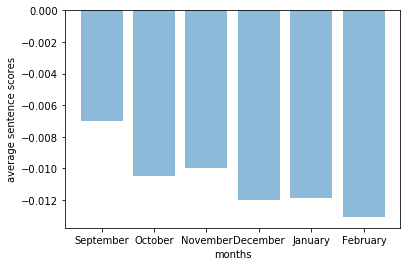

In [164]:
plt.bar(resultingM, results, align = 'center', alpha = 0.5,tick_label =['September','October','November','December','January','February'])
plt.show()
plt.xlabel("months")
plt.ylabel("average sentence scores")
